In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from random import random
import torch
from torch import nn
import torch.nn.functional as F
import albumentations as A

import cv2
import math
from net.mtcnn import *

In [11]:
mode = 'val'
net_name = 'onet'
data_path = f'/data/grey/WIDER_FACE/{net_name}_{mode}set/label_list_data.npy'
net_path = f'/data/grey/WIDER_FACE/{net_name}_{mode}set/label_list_net.npy'
img_path = f'/data/grey/WIDER_FACE/{net_name}_{mode}set/img48x48'

data_list = np.load(data_path)
net_list = np.load(net_path)
img_list = os.listdir(img_path)

label_list = np.vstack([net_list, data_list[:, :5]])
np.save(f'/data/grey/WIDER_FACE/{net_name}_{mode}set/label_list', label_list)

len(img_list), label_list.shape

(283465, (165225, 5))

In [171]:
det = np.array([[434, 34, 185, 185]])
reg = np.array([[-2.39203787e-01,  1.55267112e-01, -3.07700939e-01, -4.60559636e-02]])
def fine_tuning(dets, bbox_reg):
        dets[:, 0] = dets[:, 0] + bbox_reg[:, 0] * dets[:, 2]
        dets[:, 1] = dets[:, 1] + bbox_reg[:, 1] * dets[:, 3]
        dets[:, 2] = dets[:, 2] * np.exp(bbox_reg[:, 2])
        dets[:, 3] = dets[:, 3] * np.exp(bbox_reg[:, 3])
        return dets
fine_tuning(det, reg)

array([[389,  62, 136, 176]])

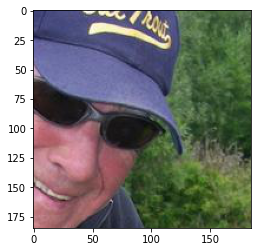

((185, 185, 3),
 array([-2.39203787e-01,  1.55267112e-01, -3.07700939e-01, -4.60559636e-02,
        -1.00000000e+00,  3.90000000e+02,  6.20000000e+01,  1.36000000e+02,
         1.76000000e+02,  4.34000000e+02,  3.40000000e+01]))

In [170]:
net_name = 'onet'
mode = 'train'
idx = 0
img_path = f'/data/grey/WIDER_FACE/{net_name}_{mode}set/img'
label_path = f'/data/grey/WIDER_FACE/{net_name}_{mode}set/label_list_data.npy'

face_list = os.listdir(img_path)

# img_name = None
# for face in face_list:
#     if face.split('-')[1].split('.')[0] == str(idx+1):
#         img_name = face
#         print(img_name)
#         break
# face = np.load(os.path.join(img_path, f'{img_name}'))
# label = np.load(label_path, allow_pickle=True)[idx]

label_list = np.load(label_path)
img = np.load(os.path.join(img_path, f'{idx + 120941}.npy'))
label = label_list[idx]

plt.figure()
plt.imshow(img)
plt.show()
# print(net_list[idx])
img.shape, label

In [110]:
img = np.array(Image.open('/data/grey/WIDER_FACE/WIDER_train/images/0--Parade/0_Parade_Parade_0_361.jpg'))
gts = np.load('/data/grey/WIDER_FACE/WIDER_train/labels/0--Parade/0_Parade_Parade_0_361.npy')
# img = np.array(Image.open('/home/grey/Documents/MTCNN/example.jpg'))


# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(1,1,1)

# for (x, y, w, h) in gts[-2:, :4]:
#     print(x, y, w, h, img.shape)
#     rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor = 'red',linewidth=2)
#     ax.add_patch(rect)
# plt.imshow(img)
# plt.show()

In [15]:
def scale_image(img, scale, w, h):
    img_scale = cv2.resize(img, (int(h * scale), int(w * scale)), interpolation=cv2.INTER_LINEAR)
    img_scale = img_scale.astype('float32')
    return img_scale

def iou(bbox1, bbox2):
    inter_x1 = np.maximum(bbox1[:, 0], bbox2[:, 0])
    inter_y1 = np.maximum(bbox1[:, 1], bbox2[:, 1])
    inter_x2 = np.minimum(bbox1[:, 0] + bbox1[:, 2], bbox2[:, 0] + bbox2[:, 2])
    inter_y2 = np.minimum(bbox1[:, 1] + bbox1[:, 3], bbox2[:, 1] + bbox2[:, 3])
    inter = np.maximum(inter_x2 - inter_x1, 0) * np.maximum(inter_y2 - inter_y1, 0)

    return inter / (bbox1[:, 2] * bbox1[:, 3] + bbox2[:, 2] * bbox2[:, 3] - inter)

# def nms(self, bboxes, threshold):
#         if len(bboxes) == 0:
#             return []
#         reserved = []
#         x1, y1, x2, y2, score = [bboxes[:, i] for i in range(5)]
#         sorted_score_indices = torch.argsort(score, descending=True)
#         while len(sorted_score_indices) > 0:
#             i = sorted_score_indices[0].item()
#             reserved.append(i)
#             iou = self._iou(
#                 (x1[i], y1[i], x2[i], y2[i]),
#                 (x1[sorted_score_indices], y1[sorted_score_indices],
#                  x2[sorted_score_indices], y2[sorted_score_indices]))
#             indices = torch.where(iou <= threshold)
#             sorted_score_indices = sorted_score_indices[indices]
#         return reserved
    
def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 0] + dets[:, 3]
    y2 = dets[:, 1] + dets[:, 2]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort().ravel()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order])
        yy1 = np.maximum(y1[i], y1[order])
        xx2 = np.minimum(x2[i], x2[order])
        yy2 = np.minimum(y2[i], y2[order])

        w, h = np.maximum(xx2 - xx1 + 1, 0), np.maximum(yy2 - yy1 + 1, 0)
        inter = w * h
        iou = inter / (areas[i] + areas[order] - inter)

        inds = np.where(iou < thresh)
        order = order[inds]

    return keep

def image_pyramid(img, min_det_size=12, min_face_size=15,factor=0.707):
    width, height = img.shape[0], img.shape[1]
    min_length = min(width, height)

    adapt_m = min_det_size / min_face_size
    min_length *= adapt_m

    scale_pyramid = []
    factor_power = 0
    while min_length > min_det_size:
        scale = adapt_m * factor ** factor_power
        scale_pyramid.append(scale)

        min_length *= factor
        factor_power += 1
        
    return scale_pyramid

def generate_bboxs(scale_pyramid, img):
    norm = A.Normalize(mean=[0.45444563, 0.39056348, 0.35925923], std=[0.27494723, 0.2613126 , 0.26158062], p=1)
    img_w, img_h = img.shape[0], img.shape[1]
    bboxes = []

    for scale in scale_pyramid:
#         print(scale)
        img_scale = cv2.resize(img, (int(img_h * scale), int(img_w * scale)), interpolation=cv2.INTER_LINEAR).astype('float32')
        img_scale = norm(image=img_scale)['image']
        img_scale = np.expand_dims(img_scale.transpose(2, 0, 1), 0)
        img_ = torch.tensor(img_scale).cuda()
        
        with torch.no_grad():
#             [pred_cls, bbox_reg] = net(img_)
            [bbox_reg, pred_cls] = net(img_)
        bbox_reg = np.squeeze(bbox_reg.cpu().numpy().transpose(2, 3, 0, 1), axis=2)

        pred_cls = pred_cls.squeeze(0).cpu()
#         pred_cls = F.softmax(pred_cls, dim=1)
        pred_cls = F.softmax(pred_cls, dim=0)
        bbox_reg = bbox_reg[np.where(pred_cls[1] > thres)]

        y, x = np.array(np.where(pred_cls[1] > thres)) * 2
        w, h = np.ones(y.shape) * 12, np.ones(x.shape) * 12
        score = pred_cls[1][pred_cls[1] > thres].flatten()

        dets = np.vstack([x, y, w, h, score]).transpose()
        keep = nms(dets, 0.5)
        dets = dets[keep]

        dets[:, 0] = dets[:, 0] - bbox_reg[keep, 0] * dets[:, 2]
        dets[:, 1] = dets[:, 1] - bbox_reg[keep, 1] * dets[:, 3]
        dets[:, 2] = dets[:, 2] * np.exp(bbox_reg[keep, 2])
        dets[:, 3] = dets[:, 3] * np.exp(bbox_reg[keep, 3])
#         dets[:, 2] = dets[:, 2] - bbox_reg[keep, 2] * dets[:, 2]
#         dets[:, 3] = dets[:, 3] - bbox_reg[keep, 3] * dets[:, 3]

        dets[:, :4] = dets[:, :4] / scale

        bboxes.append(dets)

    bboxes = np.vstack(bboxes)
    keep = nms(bboxes, 0.7)

    return bboxes[keep]
            
# net = PNet().cuda()
# net.load_state_dict(torch.load('/home/grey/Documents/mtcnn_model_saving/pnet_timesler.pt'))

# pnet = torch.load('/home/grey/Documents/mtcnn_model_saving/pnet.pth')
# rnet = torch.load('/home/grey/Documents/mtcnn_model_saving/rnet.pth')


# bboxes = generate_bboxs([0.8, 0.5656, 0.3998792, 0.2827145, 0.1998792, 0.1413146], img)
# bboxes = generate_bboxs(image_pyramid(img), img)

# num = 0
# for bbox in bboxes:
#     bbox = bbox.reshape(-1, 5)
#     ious = iou(bbox, gts)
#     num += (ious > 0.4).sum()
#     if (ious > 0.4).sum() > 0:
#         print(bbox.astype('int'), gts[ious > 0.4], ious[ious > 0.4], img.shape)
# print(num, gts.shape)


# fig = plt.figure(figsize=(20, 20))
# ax = fig.add_subplot(1,1,1)
# for (x, y, w, h) in bboxes[:, :4].astype('int'):

#     rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor = 'red',linewidth=2)
#     ax.add_patch(rect)
# plt.imshow(img)
# plt.show()

In [146]:
class Bridge:
    def __init__(self, mode='train', net_dataset='onet'):
        self.mode = mode
        self.net = net_dataset

        self.pnet = torch.load('/home/grey/Documents/mtcnn_model_saving/pnet/91-pnet-0.911.pth')
        self.rnet = torch.load('/home/grey/Documents/mtcnn_model_saving/rnet/111-rnet-0.910.pth')
        self.onet = torch.load('/home/grey/Documents/mtcnn_model_saving/onet/103-onet-0.946.pth')

        self.img_path = f'/data/grey/WIDER_FACE/WIDER_{mode}/images'
        self.label_path = f'/data/grey/WIDER_FACE/WIDER_{mode}/labels'
        self.save_path = f'/data/grey/WIDER_FACE/{self.net}_{mode}set/'

        self.mean = [0.45650857, 0.39260386, 0.36109988]
        self.std = [0.27675595, 0.26248012, 0.26266556]
    
        self.norm = A.Normalize(mean=self.mean, std=self.std, p=1)

        self.faces_count = 1
        self.pos_count = 1
        self.par_count = 1
        self.neg_count = 1

        self.labels = []

    def generate_dataset(self, face_thres=[0.6, 0.7, 0.8], nms_thres=[0.7, 0.7, 0.2]):
        cate_list = os.listdir(self.img_path)

        for cate in cate_list:
            img_list = os.listdir(os.path.join(self.img_path, cate))

            for img_file in img_list:
                label_file = img_file.replace('jpg', 'npy')
                img = np.array(Image.open(os.path.join(self.img_path, cate, img_file)))
                gts = np.load(os.path.join(self.label_path, cate, label_file))[:4]

                bboxes = self.pnet_output(img, face_thres[0], nms_thres[0])
                if self.net == 'onet':
                    bboxes = self.rnet_output(bboxes, img, face_thres[1], nms_thres[1])

                self.save_net_set(bboxes, img, gts, self.net)

#         np.save(os.path.join(self.save_path, 'label_list_net'), self.labels)

    def pnet_output(self, img, face_threshold, nms_threshold):
        img_w, img_h = img.shape[0], img.shape[1]
        scale_pyramid = image_pyramid(img)

        bboxes = []

        for scale in scale_pyramid:
            img_scale = scale_image(img, scale, img_w, img_h)
            img_ = self._img2normalize_tensor(img_scale)

            with torch.no_grad():
                [pred_cls, bbox_reg] = self.pnet(img_)
                # [bbox_reg, pred_cls] = self.pnet(img_)

            dets = self._scale_img_boxes(pred_cls, bbox_reg, scale, face_threshold)
            bboxes.append(dets)

        bboxes = np.vstack(bboxes)
        keep = nms(bboxes, nms_threshold)

        return bboxes[keep]

    def rnet_output(self, bboxes, img, face_threshold, nms_threshold):
        img_w, img_h = img.shape[0], img.shape[1]

        faces = torch.zeros((bboxes.shape[0], 3, 24, 24)).cuda()
        for idx, bbox in enumerate(bboxes):
            face, _ = self.generate_face(img, bbox, img_w, img_h, (24, 24))
            faces[idx] = self._img2normalize_tensor(face)
        
        with torch.no_grad():
            [pred_cls, bbox_reg] = self.rnet(faces)

        pred_cls = F.softmax(pred_cls.cpu(), dim=1)
        bboxes = bboxes[np.where(pred_cls[:, 1] > face_threshold)]

        bbox_reg = np.array(bbox_reg.cpu())[np.where(pred_cls[:, 1] > face_threshold)]
        bboxes = self.fine_tuning(bboxes, bbox_reg)

        keep = nms(bboxes, nms_threshold)
#         print(bbox_reg[keep])

        return bboxes[keep]

    def onet_output(self, bboxes, img, face_threshold, nms_threshold):
        img_w, img_h = img.shape[0], img.shape[1]

        faces = torch.zeros((bboxes.shape[0], 3, 48, 48)).cuda()
        for idx, bbox in enumerate(bboxes):
            face, _ = self.generate_face(img, bbox, img_w, img_h, (48, 48))
            faces[idx] = self._img2normalize_tensor(face)
        
        with torch.no_grad():
            [pred_cls, bbox_reg] = self.onet(faces)
#             print(bbox_reg)

        pred_cls = F.softmax(pred_cls.cpu(), dim=1)
        bboxes = bboxes[np.where(pred_cls[:, 1] > face_threshold)]

        bbox_reg = np.array(bbox_reg.cpu())[np.where(pred_cls[:, 1] > face_threshold)]
#         bboxes = self.fine_tuning(bboxes, bbox_reg)

        keep = nms(bboxes, nms_threshold)
        return bboxes[keep]

    def _img2normalize_tensor(self, img):
        img = self.norm(image=img)['image']
        img = np.expand_dims(img.transpose(2, 0, 1), 0)
        img_ = torch.tensor(img).cuda()
        return img_

    def _scale_img_boxes(self, pred_cls, bbox_reg, scale, thres):
        pred_cls = pred_cls.squeeze(0).cpu()
        pred_cls = F.softmax(pred_cls, dim=0)

        bbox_reg = np.squeeze(bbox_reg.cpu().numpy().transpose(2, 3, 0, 1), axis=2)
        bbox_reg = bbox_reg[np.where(pred_cls[1] > thres)]

        y, x = np.array(np.where(pred_cls[1] > thres)) * 2
        w, h = np.ones(y.shape) * 12, np.ones(x.shape) * 12
        score = pred_cls[1][pred_cls[1] > thres].flatten()

        dets = np.vstack([x, y, w, h, score]).transpose()
        keep = nms(dets, 0.5)

        dets = dets[keep]
        bbox_reg = bbox_reg[keep]

        dets = self.fine_tuning(dets, bbox_reg)
        dets[:, :4] = dets[:, :4] / scale

        return dets

    def fine_tuning(self, dets, bbox_reg):
        dets[:, 0] = dets[:, 0] + bbox_reg[:, 0] * dets[:, 2]
        dets[:, 1] = dets[:, 1] + bbox_reg[:, 1] * dets[:, 3]
        dets[:, 2] = dets[:, 2] * np.exp(bbox_reg[:, 2])
        dets[:, 3] = dets[:, 3] * np.exp(bbox_reg[:, 3])
        return dets

    def save_net_set(self, bboxes, img, gts, net):
        img_w, img_h = img.shape[0], img.shape[1]
        size = (24, 24) if net == 'rnet' else (48, 48)
        img_size = '24x24' if net == 'rnet' else '48x48'

        for bbox in bboxes:
            face, label = self.generate_img_and_label(img, gts, bbox, img_w, img_h, size)

    def generate_img_and_label(self, img, gts, bbox, img_w, img_h, size):
        face, bbox = self.generate_face(img, bbox, img_w, img_h, size)

        bbox_ = bbox.reshape(-1, 5)
        ious = iou(bbox_, gts)

        # negitive sample
        label = np.zeros(5)

        # positive sample
        idx = np.where(ious > 0.6)[0]
        if len(idx):
            gt = gts[idx][0]
            label[-1] = 1

            label[0] = (gt[0] - bbox[0]) / bbox[2]
            label[1] = (gt[1] - bbox[1]) / bbox[3]
            label[2] = np.log(gt[2] / bbox[2])
            label[3] = np.log(gt[3] / bbox[3])
            
#             print(label, gts[idx, :4], bbox)

        # part sample
        elif len(np.where(ious > 0.3)[0]):
            idx = np.where(ious > 0.3)[0]

            gt = gts[idx][0]
            label[-1] = -1

            label[0] = (gt[0] - bbox[0]) / bbox[2]
            label[1] = (gt[1] - bbox[1]) / bbox[3]
            label[2] = np.log(gt[2] / bbox[2])
            label[3] = np.log(gt[3] / bbox[3])

        return face, label

    def generate_face(self, img, bbox, img_w, img_h, size):
        bbox = bbox.astype('int')

        side = max(bbox[2], bbox[3])
        bbox[2], bbox[3] = side, side

        face = img[max(bbox[1], 0):min(bbox[1] + bbox[2], img_w), max(bbox[0], 0):min(bbox[0] + bbox[3], img_h)]

        if 0 > bbox[1]:
            face = np.pad(face, ((-bbox[1], 0), (0, 0), (0, 0)), 'constant')
        if 0 > bbox[0]:
            face = np.pad(face, ((0, 0), (-bbox[0], 0), (0, 0)), 'constant')
        if bbox[1] + bbox[2] > img_w:
            face = np.pad(face, ((0, bbox[1] + bbox[2] - img_w), (0, 0), (0, 0)), 'constant')
        if bbox[0] + bbox[3] > img_h:
            face = np.pad(face, ((0, 0), (0, bbox[0] + bbox[3] - img_h), (0, 0)), 'constant')

        face = Image.fromarray(face)
        face = np.array(face.resize(size))
        return face, bbox

    
bridge = Bridge('train', 'onet')
bboxes = bridge.pnet_output(img, 0.8, 0.7)
bboxes = bridge.rnet_output(bboxes, img, 0.8, 0.5)
bboxes = bridge.onet_output(bboxes, img, 0.8, 0.2)
bboxes.shape
# bridge.generate_dataset()

(60, 5)

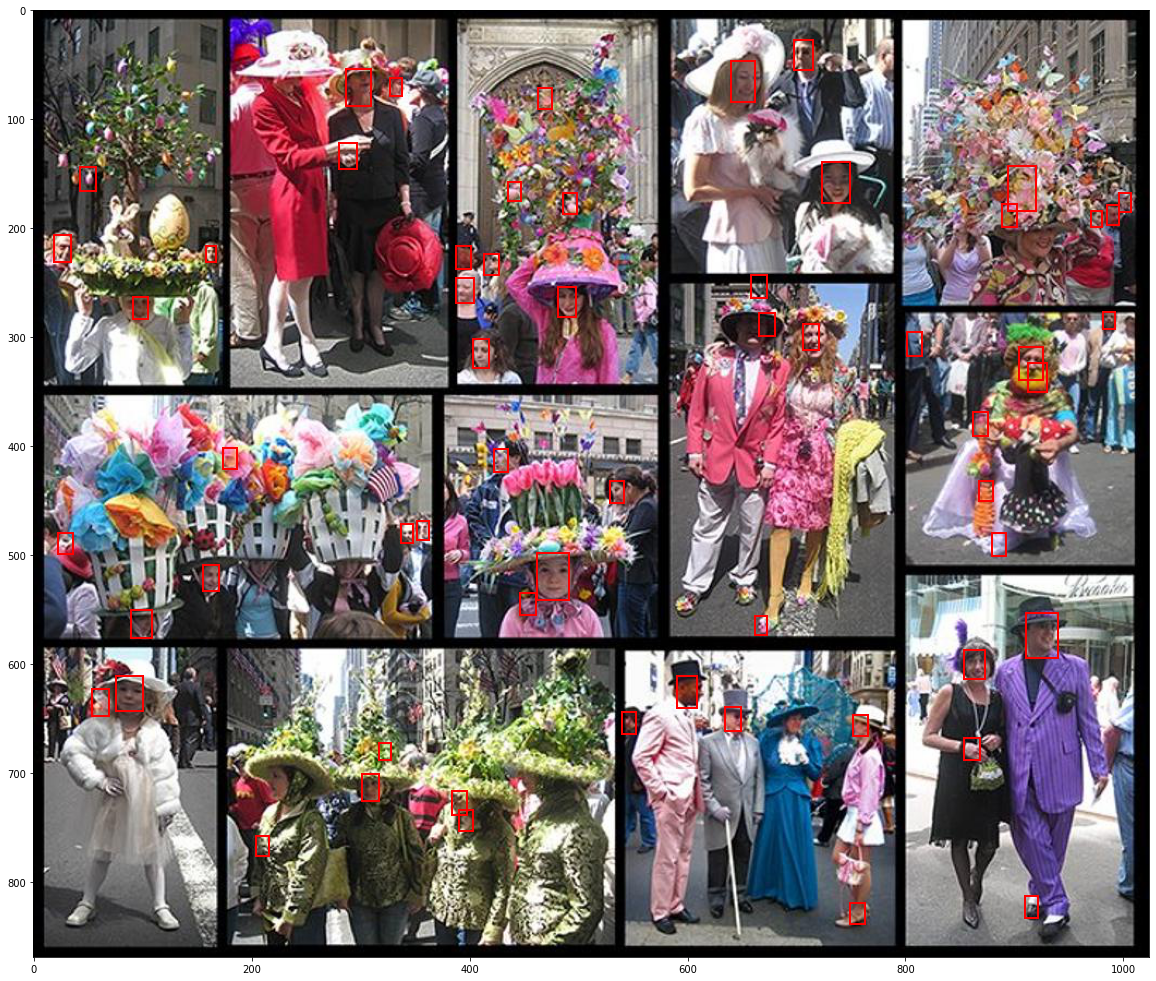

In [147]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1,1,1)
for (x, y, w, h) in bboxes[:, :4].astype('int'):

    rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor = 'red',linewidth=2)
    ax.add_patch(rect)
plt.imshow(img)
plt.show()